<a href="https://colab.research.google.com/github/kavyapatel02/FLT3-QSAR-Model/blob/main/FLT3!!!!!!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install chembl_webresource_client
import pandas as pd
from chembl_webresource_client.new_client import new_client as nc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install biotite
!pip install rdkit
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from rdkit.Chem import AllChem
from rdkit import Chem

In [3]:
target = nc.target
target_query = target.search('FLT3')
targets = pd.DataFrame.from_dict(target_query)
targets

selected_target = targets.target_chembl_id[1]
selected_target

activity = nc.activity
res = activity.filter(target_chembl_id = selected_target).filter(standard_type = ['IC50'])
df = pd.DataFrame.from_dict(res)
df

df.dropna(subset = ('standard_value')).reset_index()

bioactivity_class = []
for i in df.standard_value:
    if pd.to_numeric(i) > 10000:
        bioactivity_class.append('Inactive')
    elif pd.to_numeric(i) < 1000:
        bioactivity_class.append('Active')
    else:
        bioactivity_class.append('Intermediate')

mol_cid = []
for i in df.molecule_chembl_id:
    mol_cid.append(i)

standard_value = []
for i in df.standard_value:
    standard_value.append(i)

canonical_smiles = []
for i in df.canonical_smiles:
    canonical_smiles.append(i)

df = pd.DataFrame({
    "molecule_chembl_id": mol_cid,
    "standard_value": standard_value,
    "smiles_notation": canonical_smiles,
    "bioactivity_class": bioactivity_class
})
df
df.rename(columns = {"bioactivity_class": "class"}, inplace = True)

In [4]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import Lipinski

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

df_lipinski = lipinski(canonical_smiles)
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,standard_value,smiles_notation,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL330863,128.0,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,Active,576.742,5.28050,1.0,8.0
1,CHEMBL124660,220.0,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,Active,562.715,5.03450,1.0,8.0
2,CHEMBL126699,8790.0,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,Intermediate,543.672,4.50748,1.0,8.0
3,CHEMBL445636,1910.0,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,Intermediate,543.672,4.36498,1.0,8.0
4,CHEMBL941,30000.0,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,Inactive,493.615,4.59032,2.0,7.0
...,...,...,...,...,...,...,...,...
5632,CHEMBL5083143,751.0,c1ccc2c(-c3coc4cc(-c5ccc(N6CCNCC6)cc5)cnc34)cc...,Active,406.489,5.11960,1.0,5.0
5633,CHEMBL5303487,200.0,COc1cc(-c2cn[nH]c2)ccc1C(=O)Nc1ccc2c(c1)CCNCC2.Cl,Active,398.894,3.44760,3.0,4.0
5634,CHEMBL5303487,520.0,COc1cc(-c2cn[nH]c2)ccc1C(=O)Nc1ccc2c(c1)CCNCC2.Cl,Active,398.894,3.44760,3.0,4.0
5635,CHEMBL4475494,177.0,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,Active,482.516,1.88300,2.0,8.0


In [5]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = pd.to_numeric(i)*(10**-9)
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop(['standard_value_norm'], axis = 1)

    return x

def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if pd.to_numeric(i) > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop(['standard_value'], axis = 1)

    return x

df_norm = norm_value(df_combined)
df_pIC50 = pIC50(df_norm)
df_pIC50

df_pIC50 = df_pIC50[df_pIC50['class'] != 'Intermediate'].reset_index(drop=True)
df_pIC50

,molecule_chembl_id,smiles_notation,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL330863,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,Active,576.742,5.28050,1.0,8.0,6.892790
1,CHEMBL124660,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,Active,562.715,5.03450,1.0,8.0,6.657577
2,CHEMBL941,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,Inactive,493.615,4.59032,2.0,7.0,4.522879
3,CHEMBL124035,COCCOc1cc2ncnc(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC...,Active,495.580,3.80490,1.0,8.0,6.346787
4,CHEMBL125898,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,Active,564.687,3.88080,1.0,9.0,7.397940
...,...,...,...,...,...,...,...,...
3300,CHEMBL5083143,c1ccc2c(-c3coc4cc(-c5ccc(N6CCNCC6)cc5)cnc34)cc...,Active,406.489,5.11960,1.0,5.0,6.124360
3301,CHEMBL5303487,COc1cc(-c2cn[nH]c2)ccc1C(=O)Nc1ccc2c(c1)CCNCC2.Cl,Active,398.894,3.44760,3.0,4.0,6.698970
3302,CHEMBL5303487,COc1cc(-c2cn[nH]c2)ccc1C(=O)Nc1ccc2c(c1)CCNCC2.Cl,Active,398.894,3.44760,3.0,4.0,6.283997
3303,CHEMBL4475494,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,Active,482.516,1.88300,2.0,8.0,6.752027


In [6]:
import os

# Download FLT3 PDB structures as specified in outline
pdb_ids = ['4RT7', '6JQR']
os.makedirs('data/flt3_structures', exist_ok=True)

for pdb_id in pdb_ids:
    try:
        from urllib.request import urlretrieve
        url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
        output_path = f'data/flt3_structures/{pdb_id}.pdb'
        urlretrieve(url, output_path)
        print(f"Downloaded {pdb_id}.pdb")
    except Exception as e:
        print(f"Failed to download {pdb_id}.pdb: {e}")

Downloaded 4RT7.pdb
Downloaded 6JQR.pdb


In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


def generate_morgan_fingerprints(smiles_list, radius=2, n_bits=2048):
    """Generate Morgan fingerprints from SMILES"""
    fingerprints = []
    valid_indices = []

    for idx, smiles in enumerate(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                # Generate Morgan fingerprint
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
                # Convert to numpy array
                fp_array = np.array(fp)
                fingerprints.append(fp_array)
                valid_indices.append(idx)
            else:
                print(f"Invalid SMILES at index {idx}: {smiles}")
        except Exception as e:
            print(f"Error processing SMILES at index {idx}: {e}")

    return np.array(fingerprints), valid_indices


# Generate Morgan fingerprints
print("Generating Morgan fingerprints...")
morgan_fps, valid_idx = generate_morgan_fingerprints(df_pIC50['smiles_notation'].tolist())


# Filter dataframe to keep only valid molecules
df_clean = df_pIC50.iloc[valid_idx].reset_index(drop=True)


print(f"Generated fingerprints for {len(morgan_fps)} compounds")
print(f"Fingerprint shape: {morgan_fps.shape}")


# Create combined dataset with fingerprints
df_final = df_clean.copy()
print(f"Final dataset shape: {df_final.shape}")


Generating Morgan fingerprints...


[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerator
[19:14:22] DEPRECATION WARNING: please use MorganGenerat

Generated fingerprints for 3305 compounds
Fingerprint shape: (3305, 2048)
Final dataset shape: (3305, 8)


[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerator
[19:14:29] DEPRECATION WARNING: please use MorganGenerat

In [16]:
print(type(morgan_fps))  # Should show <class 'numpy.ndarray'>
print(morgan_fps.shape)  # Should be (n_molecules, 2048)

# See the first fingerprint
print(morgan_fps[0][:10])

<class 'numpy.ndarray'>
(3305, 2048)
[0 1 0 0 0 0 0 0 0 0]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 46.4 MB/s eta 0:00:00


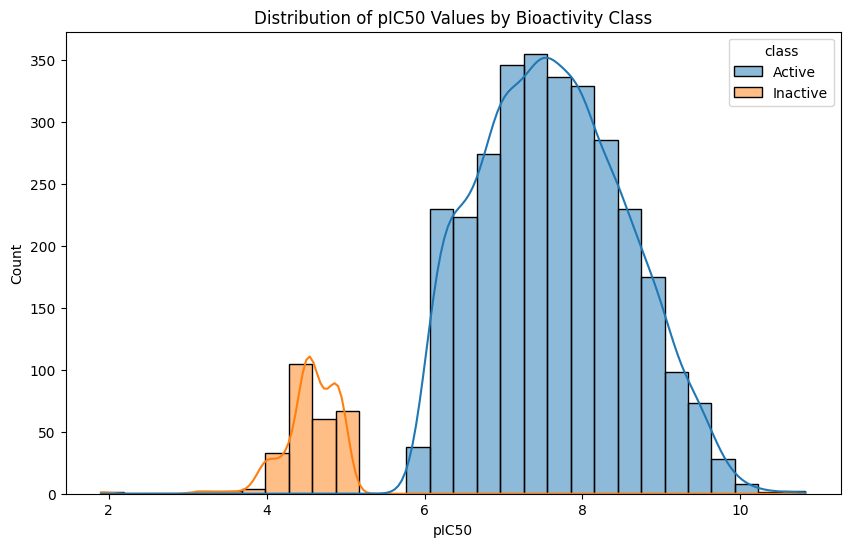

In [3]:
!pip install chembl_webresource_client
import pandas as pd
from chembl_webresource_client.new_client import new_client as nc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install biotite
!pip install rdkit
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from rdkit.Chem import AllChem
from rdkit import Chem

plt.figure(figsize=(10, 6))
sns.histplot(data=df_final, x='pIC50', hue='class', bins=30, kde=True)
plt.title('Distribution of pIC50 Values by Bioactivity Class')
plt.xlabel('pIC50')
plt.show()

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Please upload your flt3_project_backup.zip file


Saving flt3_project_backup.zip to flt3_project_backup.zip
Archive:  flt3_project_backup.zip
   creating: flt3_saved_data/
   creating: flt3_saved_data/flt3_structures/
  inflating: flt3_saved_data/flt3_structures/6JQR.pdb  
  inflating: flt3_saved_data/flt3_structures/4RT7.pdb  
  inflating: flt3_saved_data/flt3_project_data.pkl  
✅ Successfully loaded:
- 3305 compounds with 2048-bit fingerprints
- PDB files: 4RT7, 6JQR
- Saved on: 2025-05-26 19:23:05.993555

Found 2 PDB files in backup


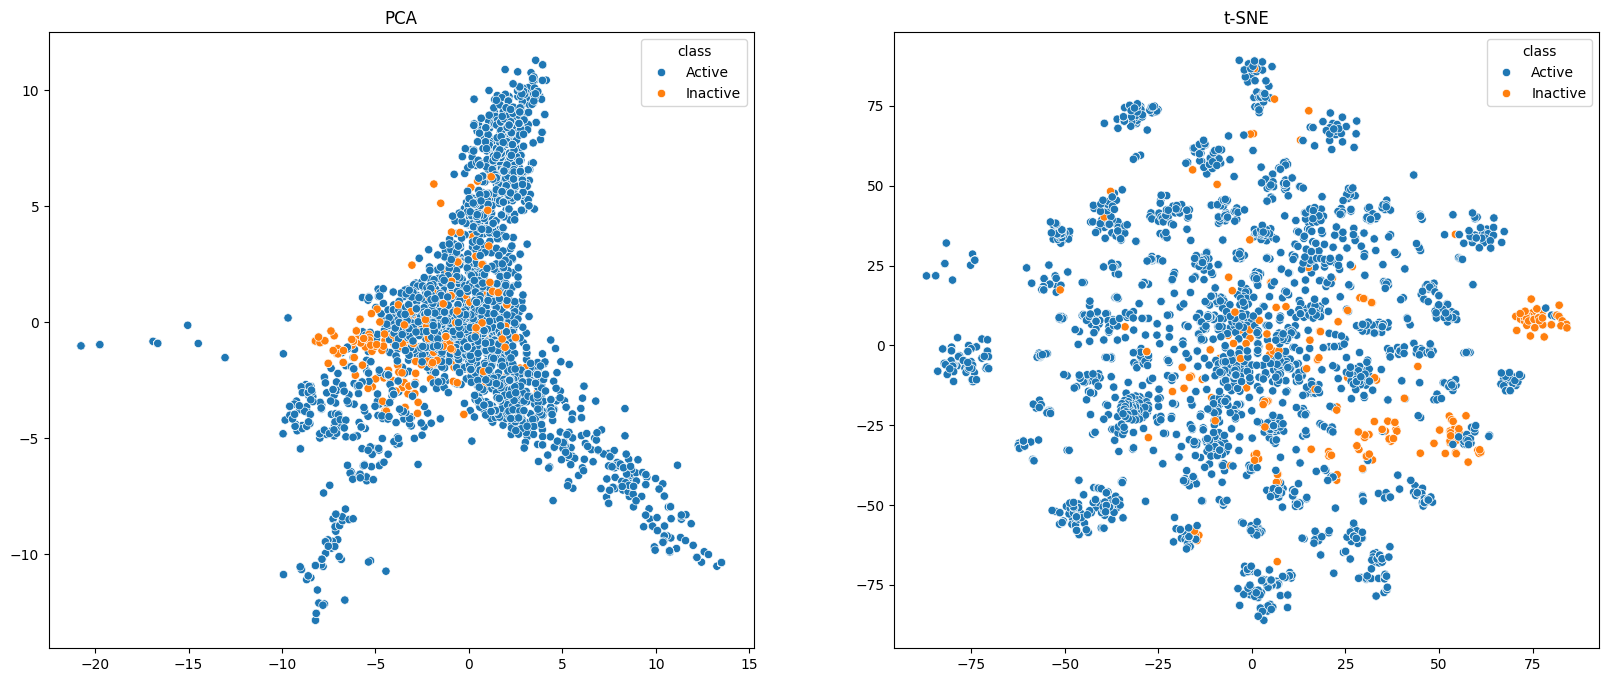

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_fps = scaler.fit_transform(morgan_fps)

# Compare both side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_fps)
sns.scatterplot(x=pca_results[:,0], y=pca_results[:,1],
                hue=df_final['class'], ax=ax1)
ax1.set_title('PCA')

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_fps)
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1],
                hue=df_final['class'], ax=ax2)
ax2.set_title('t-SNE')

plt.show()

In [12]:
df_final

x = morgan_fps
y = df_final['pIC50'].values

In [13]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [18]:
x.shape

(3305, 2048)

In [30]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(0.01))
x = selection.fit_transform(x)
x.shape
y.shape

(3305,)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, y_train.shape
x_test.shape, y_test.shape

((661, 42), (661,))

In [34]:
model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)
r = model.score(x_test, y_test)
r

0.5446174498847229

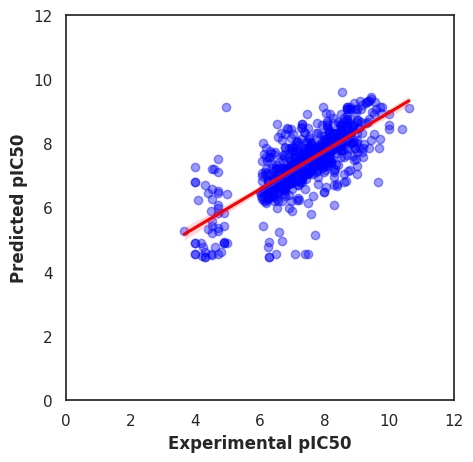

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Ensure Y_pred exists (critical!)
y_pred = model.predict(x_test)  # Generate predictions first

# 2. Plot with named parameters
sns.set(color_codes=True)
sns.set_style("white")

plt.figure(figsize=(5, 5))
ax = sns.regplot(x=y_test, y=y_pred,  # Explicit x/y names
                 scatter_kws={'alpha': 0.4, 'color': 'blue'},
                 line_kws={'color': 'red'})

ax.set_xlabel('Experimental pIC50', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize=12, fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
plt.show()

In [41]:
!pip install lazypredict
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [42]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(x_train, x_train, y_train, y_train)
models_test,predictions_test = clf.fit(x_train, x_test, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 2644, number of used features: 42
[LightGBM] [Info] Start training from score 7.372492
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 2644, number of used features: 42
[LightGBM] [Info] Start training from score 7.372492


In [43]:
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreeRegressor,0.90,0.90,0.39,0.08
DecisionTreeRegressor,0.90,0.90,0.39,0.10
ExtraTreesRegressor,0.90,0.90,0.39,3.12
GaussianProcessRegressor,0.90,0.90,0.39,4.30
XGBRegressor,0.88,0.88,0.42,0.26
RandomForestRegressor,0.86,0.87,0.45,1.82
BaggingRegressor,0.85,0.85,0.47,0.45
MLPRegressor,0.79,0.79,0.56,5.37
HistGradientBoostingRegressor,0.75,0.76,0.60,1.40


In [44]:
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.52,0.55,0.82,1.33
XGBRegressor,0.51,0.54,0.82,0.22
HistGradientBoostingRegressor,0.49,0.52,0.84,0.43
BaggingRegressor,0.48,0.51,0.85,0.16
MLPRegressor,0.48,0.51,0.85,5.23
NuSVR,0.47,0.51,0.85,0.94
LGBMRegressor,0.47,0.51,0.85,0.13
SVR,0.47,0.50,0.86,0.71
KNeighborsRegressor,0.44,0.47,0.88,0.05


[(0.0, 1.0)]

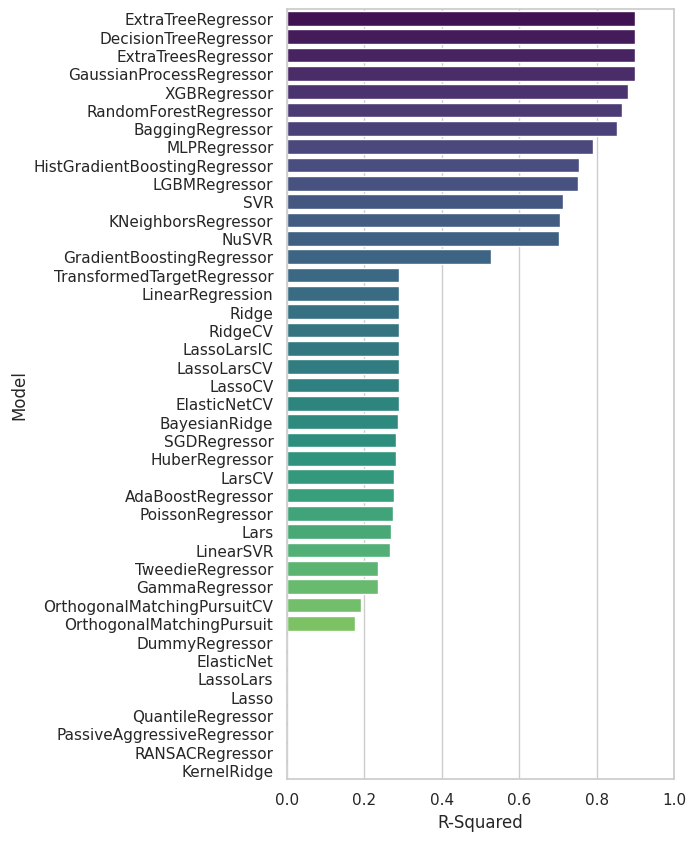

In [45]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train, palette = 'viridis')
ax.set(xlim=(0, 1))


[(0.0, 10.0)]

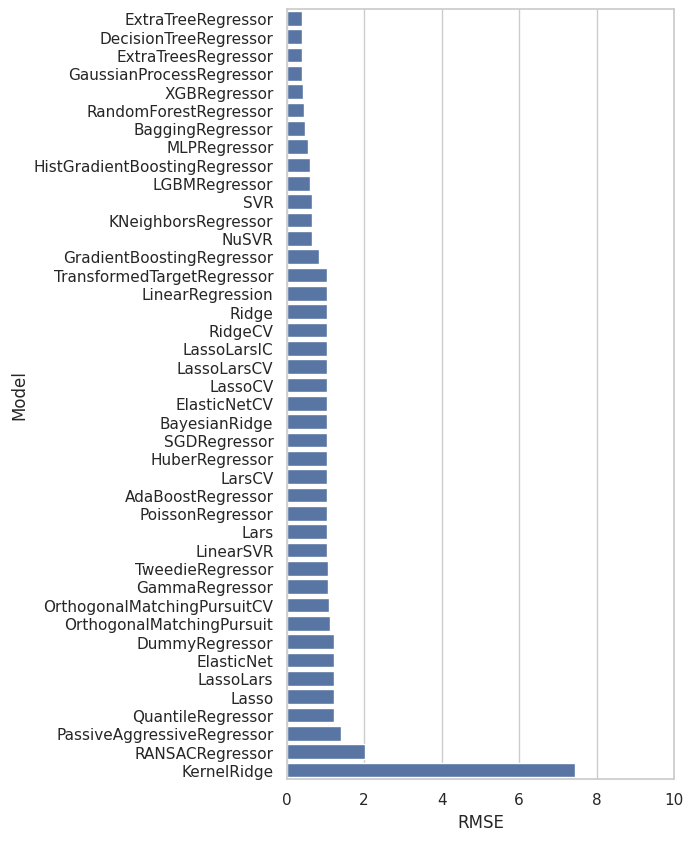

In [46]:

# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

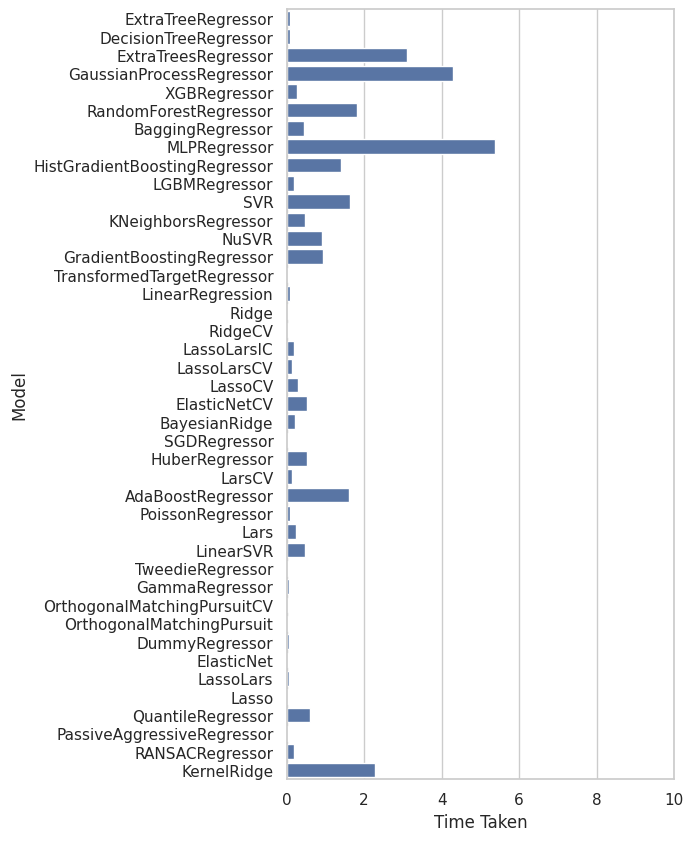

In [47]:

# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid.fit(x_train, y_train)
print(f"Best R²: {grid.best_score_:.3f}")

Best R²: 0.596


In [57]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(grid.best_estimator_, x, y, cv=5)
print(f"CV R²: {np.mean(cv_scores):.2f} (±{np.std(cv_scores):.2f})")

CV R²: 0.26 (±0.10)


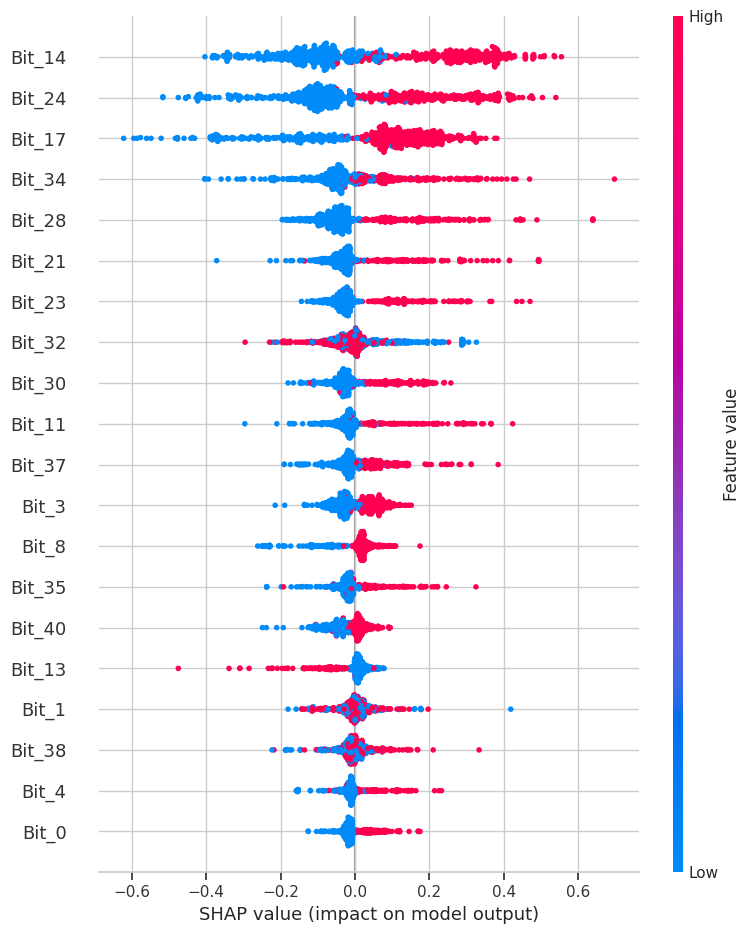

In [49]:
!pip install shap
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, feature_names=[f"Bit_{i}" for i in range(x_test.shape[1])])

In [52]:
!pip install nglview biopandas py3Dmol

In [54]:
import py3Dmol
import requests

# Fetch PDB file directly from RCSB
pdb_id = "4RT7"  # or "6JQR"
url = f"https://files.rcsb.org/view/{pdb_id}.pdb"

# Display structure
view = py3Dmol.view(width=800, height=600)
view.addModel(requests.get(url).text, "pdb")
view.setStyle({"cartoon": {"color": "spectrum"}})
view.addStyle({"resi": "835"}, {"stick": {"color": "red"}})  # Highlight D835
view.addStyle({"resi": "691"}, {"stick": {"color": "blue"}}) # Highlight F691
view.zoomTo({"resi": "835"})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [56]:
import plotly.express as px

# Project fingerprints to 3D
pca_3d = PCA(n_components=3).fit_transform(x)
df_plot = pd.DataFrame(pca_3d, columns=["PC1","PC2","PC3"])
df_plot["pIC50"] = y

fig = px.scatter_3d(df_plot, x='PC1', y='PC2', z='PC3', color='pIC50',
                    hover_data={"smiles": df_final["smiles_notation"]})
fig.update_layout(scene=dict(aspectmode="cube"))
fig.show()